# Evaluación 1 - Entrenando redes feedforward

**Autores:**

+ Lucas Poblete
+ Jorge Riffo

**Correos Electrónicos:**

+ luc.poblete@duocuc.cl
+ j.riffo@duocuc.cl

**Fecha de Creación:** Abril de 2025  
**Versión:** 1.0  

---

## Descripción

Este notebook contiene el desarrollo de la evaluación 1 de la asignatura de Deep Learning de la carrera de Ingeniería en Informática de DuocUC sede Concepción.

---

## Requisitos de Software

Este notebook fue desarrollado con Python ...

# Carga de datos

In [4]:
import urllib.request
import os

files = [
    ("train-images-idx3-ubyte.gz", "https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz"),
    ("train-labels-idx1-ubyte.gz", "https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz"),
    ("t10k-images-idx3-ubyte.gz", "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz"),
    ("t10k-labels-idx1-ubyte.gz", "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz"),
]

for filename, url in files:
    if os.path.exists(filename):
        os.remove(filename)
    print(f"Downloading {filename}...")
    urllib.request.urlretrieve(url, filename)
    print(f"Downloaded {filename} successfully!")


Downloaded train-images-idx3-ubyte.gz successfully!
Downloaded train-labels-idx1-ubyte.gz successfully!
Downloaded t10k-images-idx3-ubyte.gz successfully!
Downloaded t10k-labels-idx1-ubyte.gz successfully!


In [3]:
import gzip
import shutil
import struct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
# Asegurar que las etiquetas están en formato correcto
from keras.utils import to_categorical

# Carga de imágenes

In [5]:
# Función para cargar imágenes MNIST
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)  # Saltar los primeros 16 bytes del encabezado
    return data.reshape(-1, 28 * 28).astype("float32") / 255.0  # Aplanar y normalizar

# Función para cargar etiquetas MNIST
def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)  # Saltar los primeros 8 bytes del encabezado
    return keras.utils.to_categorical(labels, 10)  # One-hot encoding para clasificación

# Cargar los datos
X_train = load_mnist_images("train-images-idx3-ubyte.gz")
y_train = load_mnist_labels("train-labels-idx1-ubyte.gz")
X_test = load_mnist_images("t10k-images-idx3-ubyte.gz")
y_test = load_mnist_labels("t10k-labels-idx1-ubyte.gz")

# Verificar dimensiones
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (60000, 784), y_train: (60000, 10)
X_test: (10000, 784), y_test: (10000, 10)


### Entradas y Salidas

In [6]:
N = X_train.shape[1]
C = y_train.shape[1]

# Muestra imágenes


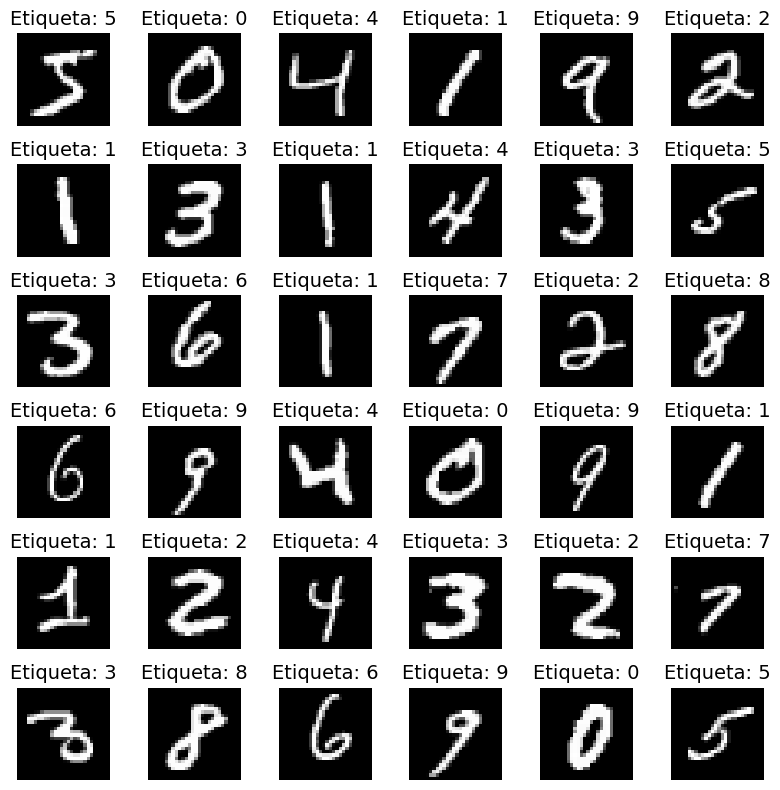

In [7]:
plt.figure(figsize=(8, 8))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f'Etiqueta: {np.argmax(y_train[i])}', fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()

Clase     Cantidad  Porcentaje
--------------------------------
0         5923      9.87%
1         6742      11.24%
2         5958      9.93%
3         6131      10.22%
4         5842      9.74%
5         5421      9.04%
6         5918      9.86%
7         6265      10.44%
8         5851      9.75%
9         5949      9.92%
--------------------------------
Total     60000     100.00%   



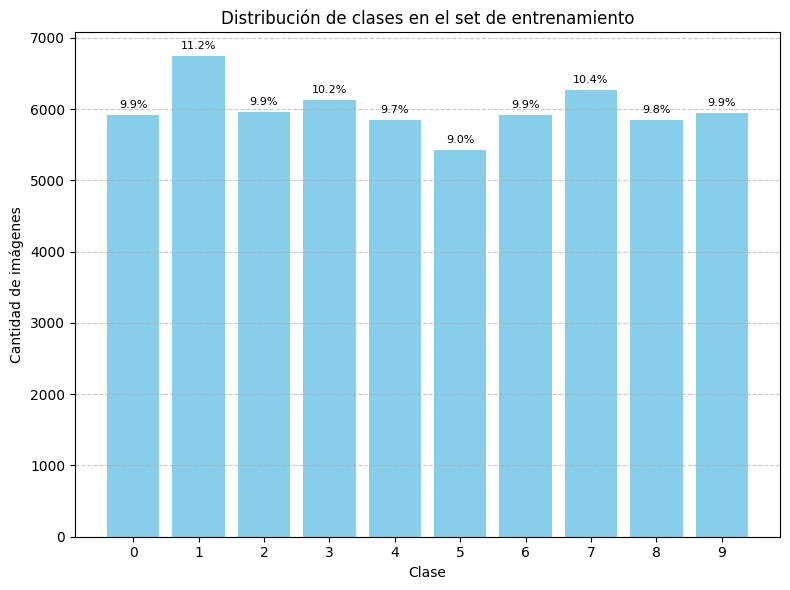

In [8]:
labels = np.argmax(y_train, axis=1)

# Contar cuántas imágenes hay de cada clase (0 al 9)
class_counts = np.bincount(labels)

# Calcular total
total = np.sum(class_counts)

print(f"{'Clase':<10}{'Cantidad':<10}{'Porcentaje':<10}")
print("-" * 32)

# Filas
for i, count in enumerate(class_counts):
    porcentaje = (count / total) * 100
    print(f"{i:<10}{count:<10}{porcentaje:.2f}%")

# Línea final con total
print("-" * 32)
print(f"{'Total':<10}{total:<10}{'100.00%':<10}\n")

# Graficar
plt.figure(figsize=(8, 6))
bars = plt.bar(range(10), class_counts, color='skyblue')
plt.xlabel("Clase")
plt.ylabel("Cantidad de imágenes")
plt.title("Distribución de clases en el set de entrenamiento")
plt.xticks(range(10))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir porcentaje sobre las barras
for bar, count in zip(bars, class_counts):
    porcentaje = (count / total) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 100,
             f"{porcentaje:.1f}%", ha='center', fontsize=8)

plt.tight_layout()
plt.show()

# Métricas importantes

## Accuracy

Determina el porcentaje de clasificaciones de imagenes correctas del modelo.

- No es muy util en casos de desbalance de clases

Formula


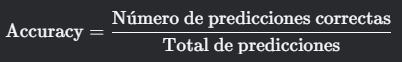

## Precision (Por clase)

Mide la calidad de las predicciones positivas

- De importancia cuando los FP son de importancia en el negocio

Formula

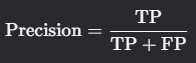

* TP (True Positives): Casos correctamente clasificados en la clase.
* FP (False Positives): Casos de otras clases erroneamente clasificados en esta.

## Recall (Por clase)

Capacidad de detectar una clase
- Crítico cuando los FN son de importancia

Formula

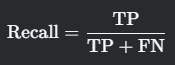

* TP (True Positives): Casos correctamente clasificados en la clase.
* FN (False Negatives): Casos de la clase que fueron erroneamente clasificados en otras.

## F1-score

Media armónica entre precision y Recall
- Util en balance entre FP y FN

Formula

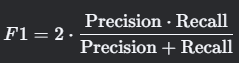

## Confusion Matrix

Muestra los valores reales vs los predichos en una matriz de todas las clases.
- Permite un analisis mas grafico de las predicciondes del modelo

Ejemplo:

## Elección de métrica para evaluar los distintos modelos de redes neuronales

Se ha elegido en este caso el Accuracy ya que el desbalance de clases no es tan relevante, es una métrica sencilla y mide la performance global del modelo. Siempre teniendo cuidado con mantener este desbalance proporcionalmente cuando se dividan los datos en datos para entrenamiento y testeo.

# Arquitecturas

Para el presente estudio de redes neuronales ocuparemos una arquitectura con 3 capas internas de 1024, 512 y 256 neuronas. Recordemos que cada capa debe tener un número de neuronas igual o menor a la anterior.

Se cambiaran los demas parametros para este estudio.

## Funciones (crear redes customizadas y graficos)

In [10]:
def crear_red_neuronal(
    N,                          # Dimension de entrada
    C,                          # Neuronas de salida (clases)
    activaciones,               # Lista de funciones de activación por capa (ej: ['relu', 'relu', 'relu', 'softmax'])
    neuronas=[1024, 512, 256],  # Neuronas por capa oculta (por defecto: [1024, 512, 256])
    dropout=None,               # None o lista de tasas de dropout por capa (ej: [0.2, 0.3, 0.1])
    nombre="Red_Personalizada"  # Nombre de la red
):
    """
    Crea una red neuronal con:
    - Activaciones personalizadas por capa.
    - Dropout opcional en capas ocultas.
    - Nombre personalizado.
    """
    red = keras.Sequential(name=nombre)
    red.add(keras.layers.Input(shape=(N,), name='entrada'))

    for i, (n_neuronas, activacion) in enumerate(zip(neuronas, activaciones[:-1])):
        red.add(keras.layers.Dense(n_neuronas, activation=activacion))
        if dropout and i < len(dropout):  # Añadir dropout si se especifica
            red.add(keras.layers.Dropout(dropout[i]))

    # Capa de salida (activación final)
    red.add(keras.layers.Dense(C, activation=activaciones[-1]))

    return red

In [20]:
def plot_history(hist, name_model):

  # Crear figura con dos subplots horizontales
  fig, axs = plt.subplots(1, 2, figsize=(14, 5))

  fig.suptitle(f'Evolución del Entrenamiento - {name_model}', fontweight="bold", fontsize=18)

  # --- Pérdida ---
  axs[0].plot(hist.history['loss'], label='Training Loss')
  axs[0].plot(hist.history['val_loss'], label='Validation Loss')
  axs[0].set_title('Pérdida', fontweight="bold", fontsize=16)
  axs[0].set_xlabel('Época', fontweight="bold", fontsize=14)
  axs[0].set_ylabel('Loss', fontweight="bold", fontsize=14)
  axs[0].legend()
  axs[0].grid(True)

  # --- Precisión ---
  axs[1].plot(hist.history['accuracy'], label='Training Accuracy')
  axs[1].plot(hist.history['val_accuracy'], label='Validation Accuracy')
  axs[1].set_title('% Acierto', fontweight="bold", fontsize=16)
  axs[1].set_xlabel('Época', fontweight="bold", fontsize=14)
  axs[1].set_ylabel('Accuracy', fontweight="bold", fontsize=14)
  axs[1].legend()
  axs[1].grid(True)

  plt.tight_layout()
  plt.show()

## Activadores

Los activadores permiten a las redes neuronales agregar componentes no lineales

## Red Adam con activador relu

In [11]:
neuronas=[1024, 512, 256]

activaciones = ['relu', 'relu', 'relu', 'softmax']  # Activaciones por capa
nombre_red = "Red_Neuronal_Adam_V1"

## Descripción red
red_adamv1_descrip = "Optimizer: Adam \n Activation: Relu + Softmax \n Drop out: No \n Loss: Categorical crossentropy"

## Crear red
red_adamv1 = crear_red_neuronal(
    N=N,
    C=C,
    neuronas=neuronas,
    activaciones=activaciones,
    dropout=None,
    nombre=nombre_red
)

In [12]:
## Compilacion de la red
red_adamv1.compile(
    loss= 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## Resumen de la red construida
red_adamv1.summary()

Model: "Red_Neuronal_Adam_V1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,462,538 (5.58 MB)

 Trainable params: 1,462,538 (5.58 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento con 30 epocas y batch size 20

In [13]:
hist_redadamv1_1 = red_adamv1.fit(
        X_train, y_train,
        epochs=30,
        batch_size=20,
        validation_data=(X_test, y_test),
        verbose=1
    )

Epoch 1/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9042 - loss: 0.3165 - val_accuracy: 0.9547 - val_loss: 0.1487
Epoch 2/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9711 - loss: 0.0941 - val_accuracy: 0.9690 - val_loss: 0.1055
Epoch 3/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9801 - loss: 0.0690 - val_accuracy: 0.9728 - val_loss: 0.0877
Epoch 4/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9839 - loss: 0.0528 - val_accuracy: 0.9749 - val_loss: 0.0957
Epoch 5/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9868 - loss: 0.0435 - val_accuracy: 0.9814 - val_loss: 0.0806
Epoch 6/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9883 - loss: 0.0404 - val_accuracy: 0.9809 - val_loss: 0.0811
Epoch 7/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.9898 - loss: 0.0333 - val_accuracy: 0.9817 - val_loss: 0.0763
Epoch 8/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9931 -

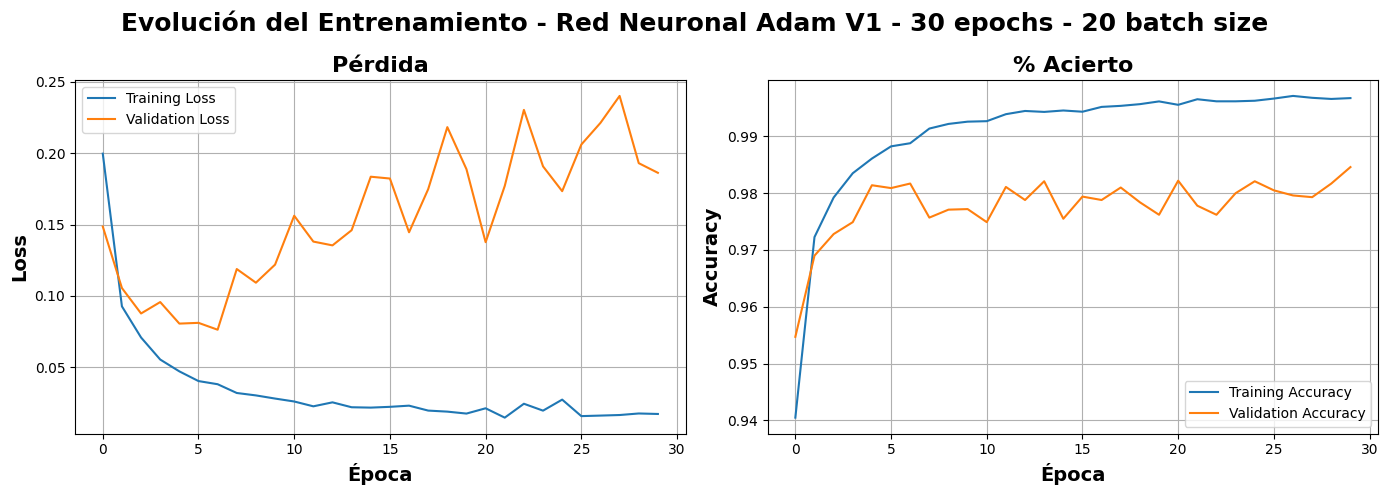

In [24]:
plot_history(hist_redadamv1_1, name_model="Red Neuronal Adam V1 - 30 epochs - 20 batch size")

### Entrenamiento con 30 epocas y batch size 100

In [16]:
## Compilacion de la red para resetear pesos
red_adamv1.compile(
    loss= 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


## Entrenamiento de la red
hist_redadamv1_2 = red_adamv1.fit(
        X_train, y_train,
        epochs=30,
        batch_size=60,
        validation_data=(X_test, y_test),
        verbose=1
    )

Epoch 1/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9987 - loss: 0.0084 - val_accuracy: 0.9844 - val_loss: 0.2934
Epoch 2/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 0.9835 - val_loss: 0.2671
Epoch 3/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9986 - loss: 0.0090 - val_accuracy: 0.9820 - val_loss: 0.2467
Epoch 4/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9988 - loss: 0.0091 - val_accuracy: 0.9846 - val_loss: 0.2940
Epoch 5/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9998 - loss: 6.1113e-04 - val_accuracy: 0.9845 - val_loss: 0.2981
Epoch 6/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9999 - loss: 1.6977e-04 - val_accuracy: 0.9860 - val_loss: 0.2956
Epoch 7/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9985 - loss: 0.0104 - val_accuracy: 0.9795 - val_loss: 0.2306
Epoch 8/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 

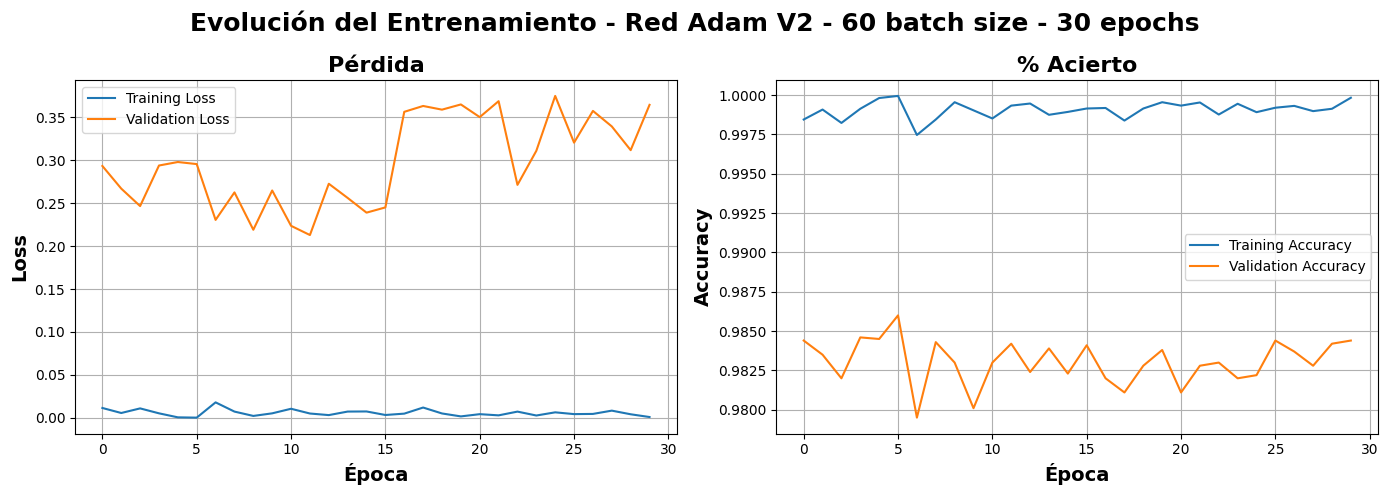

In [25]:
plot_history(hist_redadamv1_2, name_model="Red Adam V2 - 60 batch size - 30 epochs")

### Entrenamiento con 50 epocas y batch size 120

In [18]:
## Compilacion de la red para resetear pesos
red_adamv1.compile(
    loss= 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


## Entrenamiento de la red
hist_redadamv1_3 = red_adamv1.fit(
        X_train, y_train,
        epochs=50,
        batch_size=120,
        validation_data=(X_test, y_test),
        verbose=1
    )

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9997 - loss: 0.0011 - val_accuracy: 0.9847 - val_loss: 0.4545
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9995 - loss: 0.0045 - val_accuracy: 0.9830 - val_loss: 0.3427
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9996 - loss: 0.0023 - val_accuracy: 0.9830 - val_loss: 0.3751
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9996 - loss: 0.0022 - val_accuracy: 0.9827 - val_loss: 0.5194
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9984 - loss: 0.0192 - val_accuracy: 0.9856 - val_loss: 0.3178
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9997 - loss: 8.7331e-04 - val_accuracy: 0.9858 - val_loss: 0.3129
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9999 - loss: 7.7281e-04 - val_accuracy: 0.9850 - val_loss: 0.3125
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 1.0000 - loss: 1.9160e-0

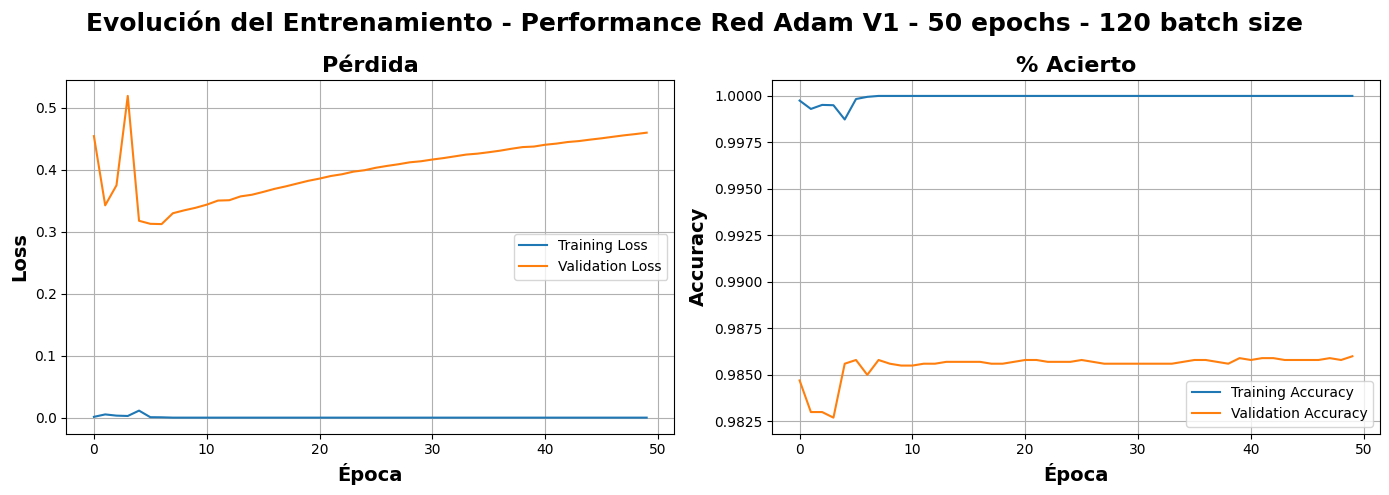

In [ ]:
plot_history(hist_redadamv1_3, name_model='Red Adam V1 3 - 50 epochs - 120 batch size')

## Resultados de experimentación 1: Cambios en batch size y epocas

Para el Optimizador Adam, la configuración de arquitectura mas conveniente es la entrenada con 30 epocas y un batch size de 20, ya que en las demas requieren de mas recursos y se obtienen resultados muy similares.

## Experimentación 2:  Cambios en Learning rate